In [1]:
%matplotlib inline
from IPython.display import display, Math
from sympy import Symbol, diff, sin, cos
from sympy.solvers import solve
from sympy.plotting import plot
from math import pi
import matplotlib.pyplot as plt
import logging
import pandas as pd
import numpy as np
import sys
import random

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

# define symbol for sympy
X = Symbol('x')

class CubicSpline():
    def __init__(self, n, x_set, fx, debug=False):
        if debug:
            logging.getLogger().setLevel(logging.DEBUG)
        
        # define all initial values
        self.fx = fx
        self.n = n
        self.x_set = x_set
        self.h = self._step_size()
        self.debug = debug
        
        # Step 1. find a
        self.a = fx
                  
                
        # Step 2. solve tridiagonal system for coefficient c
        self.c = self._solve_c()
        
        
        # Step 3. find b
        self.b = []
        for i in range(self.n):
            if i == self.n - 1:
                self.b.append(
                    (self.a[i + 1] - self.a[i]) / self.h[i] - 
                    (self.h[i] * (2 * self.c[i])) / 3)
            else:
                self.b.append(
                    (self.a[i + 1] - self.a[i]) / self.h[i] - 
                    (self.h[i] * (2 * self.c[i] + self.c[i + 1])) / 3)
        
        
        # Step 4. find d
        self.d = []
        for i in range(self.n):
            if i == self.n - 1:
                self.d.append((0 - self.c[i]) / (3 * self.h[i]))
            else:
                self.d.append(((self.c[i + 1] - self.c[i]) / (3 * self.h[i])).item(0))
            
            
        # print some calculated value for debug
        logging.debug("a[{}] = {}".format(len(self.a), self.a))
        logging.debug("b[{}] = {}".format(len(self.b), self.b))
        logging.debug("c[{}] = {}".format(len(self.c), self.c))
        logging.debug("d[{}] = {}".format(len(self.d), self.d))
        logging.debug("h[{}] = {}".format(len(self.h), self.h))
    
    
        # merge all data to a table
        self.table = pd.DataFrame({
            '$a_{j}$': self.a[:-1],
            '$b_{j}$': self.b,
            '$c_{j}$': self.c,
            '$d_{j}$': self.d
        })
    
        
    def _step_size(self):
        """Calculate the step size between each item in x_set.
            Args:
                - None
            
            Return:
                - list: the set of step size from x
        """
        sizes = []
        for i in range(len(self.x_set) - 1):
            sizes.append(self.x_set[i + 1] - self.x_set[i])
        return sizes
    
    
    def _solve_c(self):
        A = np.zeros((self.n - 1, self.n - 1))
        B = np.zeros((self.n - 1, 1))
        
        for row in range(self.n - 1):
            if row == 0:
                A[row][0] = 2 * (self.h[row] + self.h[row + 1])
                A[row][1] = self.h[row + 1]
            elif row == self.n - 2:
                A[row][-2] = self.h[-1]
                A[row][-1] = 2 * (self.h[-2] + self.h[-1])
            else:
                A[row][row - 1] = self.h[row]
                A[row][row] = 2 * (self.h[row] + self.h[row + 1])
                A[row][row + 1] = self.h[row + 1]
        
        
        for row in range(len(self.x_set) - 2):
            B[row][0] = (3 * (self.a[row + 2] - self.a[row + 1])) / self.h[row + 1] - (3 * (self.a[row + 1] - self.a[row])) / self.h[row]
            
        C = np.linalg.solve(A, B)
        C = np.insert(C, 0, 0, axis=0)
        C = C.flatten()
        
        logging.debug("A[{}] = {}".format(len(A), A))
        logging.debug("B[{}] = {}".format(len(B), B))
        logging.debug("C[{}] = {}".format(len(C), C))
        return C
    
    
    def predict(self, test_x):
        """Predict a scpecific S(x) from a cubic spline.
            Args:
                - test_x: the variable of x.
                
            Return:
                - float: the result of S(x)
        """
        for i in range(self.n):
            if test_x >= self.x_set[i] and test_x <= self.x_set[i + 1]:
                return self.a[i] + self.b[i] * (test_x - self.x_set[i]) + self.c[i] * (test_x - self.x_set[i]) ** 2 + self.d[i] * (test_x - self.x_set[i]) ** 3
    
    
    def show_table(self):
        """Display the coefficients of the natural cubic spline
            Args:
                - None
                
            Return:
                - None
        """
        display(self.table)
    
    
    def plot(self, scale=True):
        """
            Args:
                - scale: to scale or not, default is True
                
            Return:
                - plot: the graph of cubic spline
        """
        for i in range(self.n):
            t = np.arange(self.x_set[i], self.x_set[i + 1], 0.0001)
            function = self.a[i] + self.b[i] * (t - self.x_set[i]) + self.c[i] * (t - self.x_set[i]) ** 2 + self.d[i] * (t - self.x_set[i]) ** 3
            plt.plot(t, function)
        
        if scale:
            ax = plt.gca()
            ax.set_aspect(1)
        
        plt.show()
        return plot

# Part (I) A natural cubic spline
## 1. Table 3.14 (textbook, p.95)

In [2]:
x = [
    0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0,
    7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3
]
fx = [
    1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25,
    2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25
]
_1 = CubicSpline(20, x, fx)

### (a)
Output the coefficients of the natural cubic spline $S(x), a_{i}, b_{i}, c_{i}, d_{i}, 0 \leq i \leq 19$.

In [3]:
_1.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,1.30,0.539624,0.000000,-0.247649
1,1.50,0.420752,-0.297179,0.946912
2,1.85,1.086803,1.407263,-2.956382
3,2.10,1.294942,-0.366567,-0.446635
4,2.60,0.593399,-1.036519,0.445051
5,2.70,-0.022191,-0.502457,0.174160
6,2.40,-0.503406,-0.032226,0.078076
7,2.15,-0.477075,0.084888,1.314171
8,2.05,-0.071316,1.267642,-1.581219
9,2.10,0.262340,-0.155455,0.043115


### (b)
Plot the graph of the natural cubic spline $S(x)$.

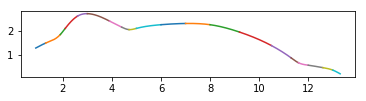

<function sympy.plotting.plot.plot>

In [4]:
_1.plot()

## 2.
A car traveling along a straight road os clocked at a number of points. Thedata from the observations are given in the following table, where the time is in seconds, and the distance in feet:

| Time ($x$) | 0 | 3 | 5 | 8 | 13 |
| --------- | - | - | - | - | -- |
| Distance ($f(x)$)|0|225|383|623|993|

In [5]:
x = [0, 3, 5, 8, 13]
fx = [0, 225, 383, 623, 993]
_2 = CubicSpline(4, x, fx)

### (a)
Output the coefficients of the natural cubic spline $S(x), a_{i}, b_{i}, c_{i}, d_{i}, 0 \leq i \leq 3$.

In [6]:
_2.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0,73.891775,0.000000,0.123136
1,225,77.216450,1.108225,-0.108225
2,383,80.350649,0.458874,-0.191919
3,623,78.227994,-1.268398,0.084560


### (b)
Plot the graph of the natural cubic spline $S(x)$.

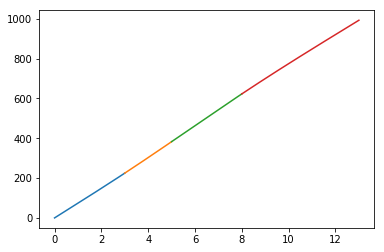

<function sympy.plotting.plot.plot>

In [7]:
_2.plot(scale=False)

### (c)
Use the natural cubic spline interpolation to predict the position of the car when $x = 10$ sec.

## 3.
The following table details the USA population from 1910 to 1980.

| Year ($x$) | 1910 | 1920 | 1930 | 1940 | 1950 | 1970 | 1980 |
| ---------  | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
|Population ($f(x)$)|91,972,266|105,710,620|122,775,046|131,669,275|150,697,361|203,235,298|226,547,082|

In [8]:
x = [1910, 1920, 1930, 1940, 1950, 1970, 1980]
fx = [91972266, 105710620, 122775046, 131669275, 150697361, 203235298, 226547082]
_3 = CubicSpline(6, x, fx)

### (a)
Output the coefficients of the natural cubic spline $S(x), a_{i}, b_{i}, c_{i}, d_{i}, 0 \leq i \leq 5$.

In [9]:
_3.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,91972266,1.209900e+06,0.000000,1639.353956
1,105710620,1.701706e+06,49180.618677,-4870.697779
2,122775046,1.224109e+06,-96940.314708,6347.168162
3,131669275,1.189453e+06,93474.730154,-2213.920869
4,150697361,2.394772e+06,27057.104090,-772.542399
5,203235298,2.459815e+06,-19295.439848,643.181328


### (b)
Plot the graph of the natural cubic spline $S(x)$.

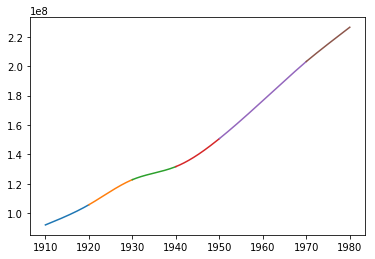

<function sympy.plotting.plot.plot>

In [10]:
_3.plot(scale=False)

### (c)
Use the natural cubic spline interpolation to predict the position of the populations in 1960.

In [11]:
_3.predict(1960)

176578246.28789967

### (d)
The real populations in 1960 is $179,323,175=f(1960)$. Calculate the relative error: $\frac{|f(1960) - S(1960)|}{|f(1960)|}$.

In [12]:
abs(179323175 - _3.predict(1960)) / abs(179323175)

0.015307161007495696

## 4.
Consider Range's function that is defined as $y = f(x) = \frac{1}{1+25x^2}$. Collect interploation data from this function on equally 11 points in the interval $[-2, 2]$.

In [13]:
f = 1 / (1 + 25 * X ** 2)
x = []
n = 11
for i in range(n):
    x.append(-2 + i * (4 / n))
fx = [f.subs(X, x[i]) for i in range(len(x))]

display(pd.DataFrame({
    '$x_{j}$': x,
    '$f(x)_{j}$': fx
}))
_4 = CubicSpline(n - 1, x, fx)

,$f(x)_{j}$,$x_{j}$
0,0.00990099009900990,-2.000000
1,0.0147184040870940,-1.636364
2,0.0240987851025692,-1.272727
3,0.0461655856543304,-0.909091
4,0.118511263467189,-0.545455
5,0.547511312217195,-0.181818
6,0.547511312217195,0.181818
7,0.118511263467189,0.545455
8,0.0461655856543304,0.909091
9,0.0240987851025692,1.272727


### (a)
Output the coefficients of the natural cubic spline $S(x), a_{i}, b_{i}, c_{i}, d_{i}, 0 \leq i \leq 10$.

In [14]:
_4.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0.00990099009900990,0.0158853554330056,0.000000,-0.019946
1,0.0147184040870940,0.00797295453568283,-0.021759,0.194625
2,0.0240987851025692,0.0693546352036274,0.190559,-0.589610
3,0.0461655856543304,-0.0259522474204922,-0.452653,2.945623
4,0.118511263467189,0.813357300986455,2.760754,-4.821227
5,0.547511312217195,0.908625287618303,-2.498767,0.000130
6,0.547511312217195,-0.908608049272122,-2.498625,4.820706
7,0.118511263467189,-0.813443492717363,2.760327,-2.943798
8,0.0461655856543304,0.0262797759979413,-0.451088,0.582831
9,0.0240987851025692,-0.0705785577825161,0.184728,-0.169334


### (b)
Plot the graph of the natural cubic spline $S(x)$.

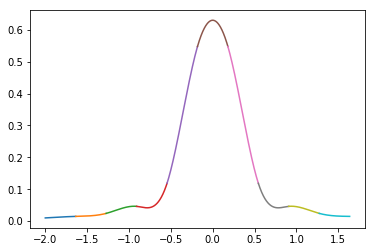

<function sympy.plotting.plot.plot>

In [15]:
_4.plot(scale=False)

## 5.
Repeat case 4 with more number of nodes. Thus, try a larger value of $n$.

In [16]:
f = 1 / (1 + 25 * X ** 2)
x = []
n = 1000
for i in range(n):
    x.append(-2 + i * (4 / n))
fx = [f.subs(X, x[i]) for i in range(len(x))]

display(pd.DataFrame({
    '$x_{j}$': x,
    '$f(x)_{j}$': fx
}))
_5 = CubicSpline(n - 1, x, fx)

,$f(x)_{j}$,$x_{j}$
0,0.00990099009900990,-2.000
1,0.00994031832875416,-1.996
2,0.00997988056078945,-1.992
3,0.0100196786488664,-1.988
4,0.0100597144650646,-1.984
5,0.0100999899000101,-1.980
6,0.0101405068630950,-1.976
7,0.0101812672827012,-1.972
8,0.0102222731064261,-1.968
9,0.0102635263013125,-1.964


### (a)
Output the coefficients of the natural cubic spline $S(x), a_{i}, b_{i}, c_{i}, d_{i}, 0 \leq i \leq 1000$.

In [17]:
_5.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0.00990099009900990,0.00981971546355515,0.000000,0.771373
1,0.00994031832875416,0.00985674138108467,0.009256,-0.200581
2,0.00997988056078945,0.00992116534676616,0.006850,0.059914
3,0.0100196786488664,0.00997883731600931,0.007568,-0.009824
4,0.0100597144650646,0.0100389135955792,0.007451,0.008924
5,0.0100999899000101,0.0100989466594701,0.007558,0.003963
6,0.0101405068630950,0.0101595982893544,0.007605,0.005355
7,0.0101812672827012,0.0102206972014453,0.007669,0.005046
8,0.0102222731064261,0.0102822954031794,0.007730,0.005194
9,0.0102635263013125,0.0103443851443025,0.007792,0.005220


### (b)
Plot the graph of the natural cubic spline $S(x)$.

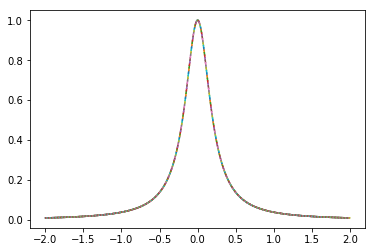

<function sympy.plotting.plot.plot>

In [18]:
_5.plot(scale=False)

In [19]:
class ParametricCurves:
    def __init__(self, n, x_set, fx, fy):        
        self.x_set = x_set
        self.fx = fx
        self.fy = fy
        
        self.x = CubicSpline(n, self.x_set, self.fx)
        self.y = CubicSpline(n, self.x_set, self.fy)
        
        
    def show_table(self):
        """Display the coefficients of the natural cubic spline
            Args:
                - None
                
            Return:
                - None
        """
        display(self.x.table)
        display(self.y.table)
        
        
    def plot(self, scale=True):
        """
            Args:
                - scale: to scale or not, default is True
                
            Return:
                - plot: the graph of a pair of cubic splines
        """
        for i in range(self.x.n):
            t = np.arange(self.x_set[i], self.x_set[i + 1], 0.001)
            function_x = self.x.a[i] + self.x.b[i] * (t - self.x_set[i]) + self.x.c[i] * (t - self.x_set[i]) ** 2 + self.x.d[i] * (t - self.x_set[i]) ** 3
            function_y = self.y.a[i] + self.y.b[i] * (t - self.x_set[i]) + self.y.c[i] * (t - self.x_set[i]) ** 2 + self.y.d[i] * (t - self.x_set[i]) ** 3
            plt.scatter(function_x, function_y, s=3)

        if scale:
            ax = plt.gca()
            ax.set_aspect(1)
                
        plt.show()
        return plot

# Part (II) A pair of natural cubic splines
## 6.
Use the following data to construct a pair of natural cubic splines $S_{x}(t)$ and $S_{y}(t)$.

|$i$| 0 | 1 | 2 | 3 | 4 |
| - | - | - | - | - | - |
|$t_{i}$|0|0.25|0.5|0.75|1
|$x_{i}$|-1|0|1|0|1|
|$y_{i}$|0|1|0.5|0|-1|

In [20]:
t = [0, 0.25, 0.5, 0.75, 1]
x = [-1, 0, 1, 0 ,1]
y = [0, 1, 0.5, 0, -1]
_6 = ParametricCurves(4, t, x, y)

### (a)
Output the coefficients of the natural cubic splines $S_{x}(t)$ and $S_{y}(t)$.

In [21]:
_6.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,-1,3.285714,0.000000,11.428571
1,0,5.428571,8.571429,-57.142857
2,1,-1.000000,-34.285714,89.142857
3,0,-1.428571,32.571429,-43.428571


,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0.0,5.642857,0.000000,-26.285714
1,1.0,0.714286,-19.714286,35.428571
2,0.5,-2.500000,6.857143,-19.428571
3,0.0,-2.714286,-7.714286,10.285714


### (b)
Plot the pair of natural cubic splines ($S_{x}(t)$, $S_{y}(t)$).

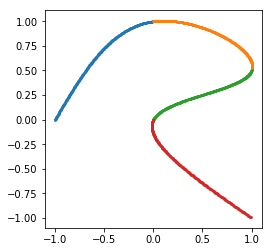

<function sympy.plotting.plot.plot>

In [22]:
_6.plot()

## 7.
Use the following data to construct a pair of natural cubic splines $S_{x}(t)$ and $S_{y}(t)$.

In [23]:
t = [i for i in range(1, 14)]
x = [7, 4, 3, 0, -3, -4, -7, -4, -3, 0, 3, 4, 7]
y = [0, 2, 5, 8, 5, 2, 0, -2, -5, -8, -5, -2, 0]
_7 = ParametricCurves(12, t, x, y)

### (a)
Output the coefficients of the natural cubic splines $S_{x}(t)$ and $S_{y}(t)$.

In [24]:
_7.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,7,-3.663953,0.000000,0.663953
1,4,-1.672095,1.991858,-1.319763
2,3,-1.647668,-1.967432,0.615100
3,0,-3.737232,-0.122132,0.859363
4,-3,-1.403405,2.455959,-2.052554
5,-4,-2.649149,-3.701702,3.350851
6,-7,0.000000,6.350851,-3.350851
7,-4,2.649149,-3.701702,2.052554
8,-3,1.403405,2.455959,-0.859363
9,0,3.737232,-0.122132,-0.615100


,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0,1.846154,0.000000e+00,0.153846
1,2,2.307692,4.615385e-01,0.230769
2,5,3.923077,1.153846e+00,-2.076923
3,8,0.000000,-5.076923e+00,2.076923
4,5,-3.923077,1.153846e+00,-0.230769
5,2,-2.307692,4.615385e-01,-0.153846
6,0,-1.846154,1.487417e-17,-0.153846
7,-2,-2.307692,-4.615385e-01,-0.230769
8,-5,-3.923077,-1.153846e+00,2.076923
9,-8,0.000000,5.076923e+00,-2.076923


### (b)
Plot the pair of natural cubic splines ($S_{x}(t)$, $S_{y}(t)$).

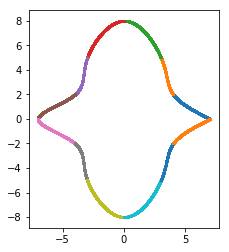

<function sympy.plotting.plot.plot>

In [25]:
_7.plot()

## 8.
An unit circle can be represented by the following parametric form:
$$ x(t) = cos t, t \in [0, 2 \pi] $$
$$ y(t) = sin t, t \in [0, 2 \pi] $$
Take $n=81$ and choose your nodes, $t_{i}$, uniformly on the interval $[0, 2 \pi]$.

In [26]:
_fx = cos(X)
_fy = sin(X)

n = 81
t = [0 + i * (2 * pi / n) for i in range(n)]

fx = [_fx.subs(X, t[i]) for i in range(len(t))]
fy = [_fy.subs(X, t[i]) for i in range(len(t))]

display(pd.DataFrame({
    '$t_{j}$': t,
    '$x(t_{j})$': fx
}))

display(pd.DataFrame({
    '$t_{j}$': t,
    '$y(t_{j})$': fy
}))

_8 = ParametricCurves(80, t, fx, fy)

,$t_{j}$,$x(t_{j})$
0,0.000000,1
1,0.077570,0.996992941167792
2,0.155140,0.987989849476809
3,0.232711,0.973044870579824
4,0.310281,0.952247885338415
5,0.387851,0.925723969268890
6,0.465421,0.893632640323412
7,0.542991,0.856166899530266
8,0.620562,0.813552070262968
9,0.698132,0.766044443118978


,$t_{j}$,$y(t_{j})$
0,0.000000,0
1,0.077570,0.0774924206719309
2,0.155140,0.154518792807840
3,0.232711,0.230615870742440
4,0.310281,0.305325997695113
5,0.387851,0.378199858171642
6,0.465421,0.448799180200462
7,0.542991,0.516699371151863
8,0.620562,0.581492071288027
9,0.698132,0.642787609686539


### (a)
Output the coefficients of the natural cubic splines $S_{x}(t)$ and $S_{y}(t)$.

In [27]:
_8.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,1,-0.0224038152599842,0.000000,-2.719207
1,0.996992941167792,-0.0714893208673438,-0.632788,0.749695
2,0.987989849476809,-0.156127283270225,-0.458326,-0.163568
3,0.973044870579824,-0.230184822267827,-0.496390,0.097143
4,0.952247885338415,-0.305441422889050,-0.473784,0.042967
5,0.925723969268890,-0.378168837489281,-0.463785,0.072750
6,0.893632640323412,-0.448807381431142,-0.446855,0.079530
7,0.856166899530266,-0.516697045427347,-0.428348,0.091878
8,0.813552070262968,-0.581492549548464,-0.406967,0.102053
9,0.766044443118978,-0.642787320788821,-0.383218,0.112049


,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0,0.999999798711953,0.000000,-0.166583
1,0.0774924206719309,0.996992740485030,-0.038766,-0.165581
2,0.154518792807840,0.987989650606261,-0.077298,-0.163584
3,0.230615870742440,0.973044674717522,-0.115366,-0.160602
4,0.305325997695113,0.952247693662298,-0.152740,-0.156655
5,0.378199858171642,0.925723782931720,-0.189195,-0.151765
6,0.448799180200462,0.893632460445842,-0.224512,-0.145963
7,0.516699371151863,0.856166727194103,-0.258479,-0.139283
8,0.581492071288027,0.813551906504660,-0.290892,-0.131765
9,0.642787609686539,0.766044288923388,-0.321555,-0.123455


### (b)
Plot the pair of natural cubic splines ($S_{x}(t)$, $S_{y}(t)$).

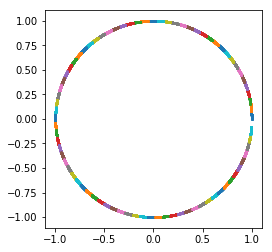

<function sympy.plotting.plot.plot>

In [28]:
_8.plot()

## 9.
Repeat case 8 with more number of nodes. Thus, try a larger value of $n$.

In [29]:
_fx = cos(X)
_fy = sin(X)

n = 1000
t = [0 + i * (2 * pi / n) for i in range(n)]

fx = [_fx.subs(X, t[i]) for i in range(len(t))]
fy = [_fy.subs(X, t[i]) for i in range(len(t))]

display(pd.DataFrame({
    '$t_{j}$': t,
    '$x(t_{j})$': fx
}))

display(pd.DataFrame({
    '$t_{j}$': t,
    '$y(t_{j})$': fy
}))

_9 = ParametricCurves(n - 1, t, fx, fy)

,$t_{j}$,$x(t_{j})$
0,0.000000,1
1,0.006283,0.999980260856137
2,0.012566,0.999921044203816
3,0.018850,0.999822352380809
4,0.025133,0.999684189283300
5,0.031416,0.999506560365732
6,0.037699,0.999289472640589
7,0.043982,0.999032934678125
8,0.050265,0.998736956606017
9,0.056549,0.998401550108975


,$t_{j}$,$y(t_{j})$
0,0.000000,0
1,0.006283,0.00628314396555895
2,0.012566,0.0125660398833526
3,0.018850,0.0188484397154082
4,0.025133,0.0251300954433375
5,0.031416,0.0314107590781283
6,0.037699,0.0376901826699345
7,0.043982,0.0439681183178649
8,0.050265,0.0502443181797696
9,0.056549,0.0565185344820245


### (a)
Output the coefficients of the natural cubic splines $S_{x}(t)$ and $S_{y}(t)$.

In [30]:
_9.show_table()

,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,1,-0.00181380533140646,0.000000,-33.632984
1,0.999980260856137,-0.00579713629172750,-0.633967,9.013642
2,0.999921044203816,-0.0126962652469496,-0.464064,-2.412159
3,0.999822352380809,-0.0188135459342132,-0.509532,0.650703
4,0.999684189283300,-0.0251394452035577,-0.497266,-0.168661
5,0.999506560365732,-0.0314082538170952,-0.500446,0.052214
6,0.999289472640589,-0.0376908539522148,-0.499461,-0.005643
7,0.999032934678125,-0.0439679384478501,-0.499568,0.011186
8,0.998736956606017,-0.0502443663752582,-0.499357,0.008003
9,0.998401550108975,-0.0565185215674740,-0.499206,0.010182


,$a_{j}$,$b_{j}$,$c_{j}$,$d_{j}$
0,0,0.999999999991341,0.000000,-0.166666
1,0.00628314396555895,0.999980260847479,-0.003142,-0.166660
2,0.0125660398833526,0.999921044195158,-0.006283,-0.166646
3,0.0188484397154082,0.999822352372152,-0.009424,-0.166627
4,0.0251300954433375,0.999684189274644,-0.012565,-0.166600
5,0.0314107590781283,0.999506560357078,-0.015705,-0.166567
6,0.0376901826699345,0.999289472631937,-0.018845,-0.166528
7,0.0439681183178649,0.999032934669474,-0.021984,-0.166482
8,0.0502443181797696,0.998736956597370,-0.025122,-0.166429
9,0.0565185344820245,0.998401550100330,-0.028259,-0.166370


### (b)
Plot the pair of natural cubic splines ($S_{x}(t)$, $S_{y}(t)$).

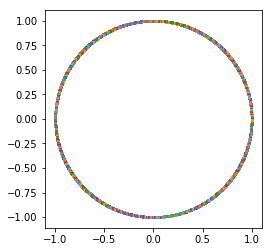

<function sympy.plotting.plot.plot>

In [31]:
_9.plot()